In [116]:
import numpy as np
import time as timing
import warnings

from lava.proc.lif.process import LIF
from lava.proc.io.source import RingBuffer as SpikeIn
from lava.proc.dense.process import Dense, DelayDense
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg
from lava.proc.monitor.process import Monitor

In [117]:
# Set this tag to "fixed_pt" or "floating_pt" to choose the corresponding models.
SELECT_TAG = "fixed_pt"

if SELECT_TAG == "fixed_pt":
    du = 4095
    dv = 4095
elif SELECT_TAG == "floating_pt":
    du = 1
    dv = 1

In [ ]:
class CreateTemplateMatchingNetwork:
    def __init__(self,
                 num_feature_detectors_per_template,
                 num_template_neurons_per_template,
                 template_neuron_thresholds_per_template,
                 input_weight_magnitude_per_template,
                 onset_feature_spikes_per_template,
                 offset_feature_spikes_per_template,
                 delays_per_weight_InConn_per_template
                 ):
        
        self.shape_template_neurons_per_template  = (num_template_neurons_per_template, )
        self.shape_input_connections_per_template = (num_template_neurons_per_template, num_feature_detectors_per_template)
        
        self.vth_per_template = template_neuron_thresholds_per_template
        
        self.input_weights_per_template = np.full(self.shape_input_connections_per_template, input_weight_magnitude_per_template)
                  
        if all(element == 0 for row in onset_feature_spikes_per_template for element in row):
            warnings.warn(f"No feature detector has spikes")
            self.onset_feature_spikes_per_template = onset_feature_spikes_per_template
        else:
            for i, row in enumerate(onset_feature_spikes_per_template):
                if all(element == 0 for element in row):
                    warnings.warn(f"Feature detector {i} hasn't fired at all.")
            
            self.onset_feature_spikes_per_template = onset_feature_spikes_per_template
        
        if all(element == 0 for row in offset_feature_spikes_per_template for element in row):
            warnings.warn(f"No feature detector has spikes")
            self.offset_feature_spikes_per_template = offset_feature_spikes_per_template
        else:
            for i, row in enumerate(offset_feature_spikes_per_template):
                if all(element == 0 for element in row):
                    warnings.warn(f"Feature detector {i} hasn't fired at all.")
            
            self.offset_feature_spikes_per_template = offset_feature_spikes_per_template
            
        self.delays_per_weight_InConn_per_template = delays_per_weight_InConn_per_template            
    
    def CreateOnsetTemplateNetwork(self):
        
        # Create input devices
        feature_spike_pattern = SpikeIn(data=self.onset_feature_spikes_per_template)

        # Create input connectivity
        conn_inp_feature_spikes = DelayDense(weights=self.input_weights,
                                             delays=self.delays_per_weight_InConn_per_template)

        # Create pre-synaptic neurons
        onset_LIF_template_A = LIF(u=0,
                                   v=0,
                                   du=du,
                                   dv=dv,
                                   bias_mant=0,
                                   bias_exp=0,
                                   vth=self.vth_per_template[0],
                                   shape=self.shape_template_neurons_per_template,
                                   name='onset_template_neuron')


        # Connect network
        feature_spike_pattern.s_out.connect(conn_inp_feature_spikes.s_in)
        conn_inp_feature_spikes.a_out.connect(onset_LIF_template_A.a_in)

In [118]:
# ============================================================================================================
# PARAMS
# ============================================================================================================
#simualtion timestep
num_timesteps               = 15
template_network_timesteps  = 10

# Neural Params
num_feature_detectors = 4
num_template_neurons  = 1

vth_template_neurons = [199]
# ============================================================================================================
# ============================================================================================================

WEIGHTS : [[50 50 50 50]]

ONSET SPIKES : 
 [[1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]]


In [ ]:
onset_feature_spikes = np.zeros((num_feature_detectors, template_network_timesteps), dtype=int)
indices = np.random.choice(template_network_timesteps, num_feature_detectors, replace=False)
indices.sort() 

for i in range(num_feature_detectors):
    onset_feature_spikes[i, indices[i]] = 1

print("ONSET SPIKES : \n", onset_feature_spikes)

In [119]:
#Creating DELAY
spike_timestamps = np.argmax(onset_feature_spikes, axis=1)
print(f"SPIKE TIMESTAMPS    : {spike_timestamps}")

all_spikes_atonce = True
when_spiking = 11


if all_spikes_atonce:
    weight_delays = [when_spiking]*4 - spike_timestamps
    delays_per_weight = weight_delays.reshape(1, 4)
else:
    random_delays = np.random.randint(2, 7, size=4)
    random_delays.sort()
    delays_per_weight = random_delays[::-1].reshape(1, 4)
    
print(f"WEIGHT DELAYS       : {delays_per_weight}\n")

zero_pad = np.zeros((onset_feature_spikes.shape[0], (num_timesteps-template_network_timesteps)))
onset_feature_spikes = np.concatenate((onset_feature_spikes, zero_pad), axis=1)
print(f"ONSET FEATURE SPIKES : \n{onset_feature_spikes}")

SPIKE TIMESTAMPS    : [0 1 2 6]
WEIGHT DELAYS       : [[11 10  9  5]]

ONSET FEATURE SPIKES : 
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [120]:
# Create input devices
feature_spike_pattern = SpikeIn(data=onset_feature_spikes)

# Create input connectivity
conn_inp_feature_spikes = DelayDense(weights=weights_delaydense,
                                     delays=delays_per_weight)

# Create pre-synaptic neurons
onset_LIF_template_A = LIF(u=0,
                           v=0,
                           du=du,
                           dv=dv,
                           bias_mant=0,
                           bias_exp=0,
                           vth=vth_template,
                           shape=shape_plateau_neurons,
                           name='onset_template_neuron')

# Connect network
feature_spike_pattern.s_out.connect(conn_inp_feature_spikes.s_in)
conn_inp_feature_spikes.a_out.connect(onset_LIF_template_A.a_in)

mon_template_spikes = Monitor()
mon_template_spikes.probe(onset_LIF_template_A.s_out, num_timesteps)


#Running
feature_spike_pattern.run(condition=RunSteps(num_steps=num_timesteps), run_cfg=Loihi2SimCfg(select_tag=SELECT_TAG))
post_delay_spikes = mon_template_spikes.get_data()['onset_template_neuron']['s_out']
feature_spike_pattern.stop()

In [121]:
spikes_with_template = delays_per_weight[0] + spike_timestamps

for i in range(onset_feature_spikes.shape[0]):
    idx = spikes_with_template[i]
    onset_feature_spikes[i,idx] += 1

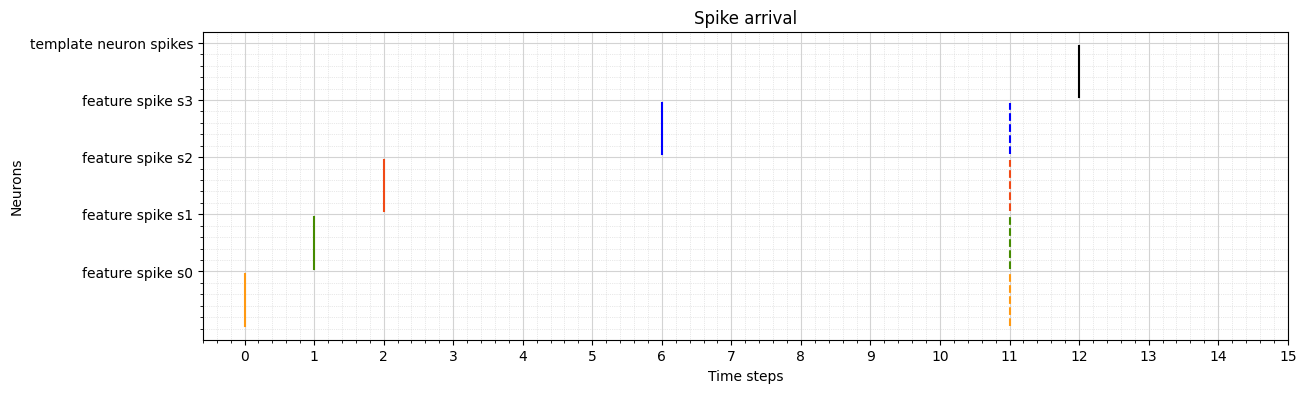

In [122]:
from utils import plot_spikes_dotted

spike_data = [onset_feature_spikes[0, :],
              onset_feature_spikes[1, :],
              onset_feature_spikes[2, :],
              onset_feature_spikes[3, :],
              post_delay_spikes[:, 0],]

# Plot spikes
plot_spikes_dotted(spikes=spike_data,
                  figsize=(14, 4),
                  legend=['feature spike s0', 'feature spike s1', 'feature spike s2', 'feature spike s3', 'template neuron spikes'], 
                  colors=['#ff9912', '#458b00',  '#f14a16', 'b', '0'],
                  title='Spike arrival',
                  num_steps=num_timesteps
                  )